In [9]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

In [62]:
df = pd.read_parquet('../../data/cleaned_tom/hi_tom_train_2000.parquet')
dfh = pd.read_parquet('../../data/cleaned_tom/hi_tom_explore_tom_test_hint.parquet')
dfe = pd.read_parquet('../data/ToM_train_800.parquet')
dft = pd.read_parquet('../data/ToM_test_1066.parquet')

In [63]:
print(len(df), len(dfh), len(dfe))

2000 1600 800


In [64]:
dfe['data_source'] = 'explore_tom'
dft['data_source'] = 'explore_tom'

In [65]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   deception       2000 non-null   bool  
 1   story_length    2000 non-null   int64 
 2   question_order  2000 non-null   int64 
 3   sample_id       2000 non-null   int64 
 4   story           2000 non-null   object
 5   question        2000 non-null   object
 6   choices         2000 non-null   object
 7   answer          2000 non-null   object
 8   question_old    2000 non-null   object
 9   answer_old      2000 non-null   object
 10  data_source     2000 non-null   object
 11  prompt          2000 non-null   object
 12  ability         2000 non-null   object
 13  reward_model    2000 non-null   object
 14  extra_info      2000 non-null   object
dtypes: bool(1), int64(3), object(11)
memory usage: 220.8+ KB


In [67]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   story_structure     800 non-null    object
 1   infilled_story      800 non-null    object
 2   question            800 non-null    object
 3   answer              800 non-null    object
 4   question_type       800 non-null    object
 5   params              800 non-null    object
 6   nth_order           800 non-null    int64 
 7   is_interesting      800 non-null    bool  
 8   story_type          800 non-null    object
 9   story_structure_wn  800 non-null    object
 10  data_source         800 non-null    object
dtypes: bool(1), int64(1), object(9)
memory usage: 63.4+ KB


In [68]:
dfs = df.groupby(['answer']).story.count().reset_index()

In [69]:
dfs = dfs.sort_values(by='story', ascending=False, ignore_index=True)
dfs.head(20)

,answer,story
0,blue_drawer,84
1,green_basket,82
2,red_drawer,80
3,red_bottle,79
4,green_bottle,77
5,green_box,77
6,blue_bucket,75
7,blue_treasure_chest,74
8,red_bucket,73
9,green_suitcase,73


In [70]:
df.question[:10]

0    Where does Lily think Gracie thinks Jackson th...
1    Where does Noah think Emily thinks Mila thinks...
2          Where does Oliver really think the peas is?
3    Where does Isabella think Amelia thinks the ap...
4    Where does Mason think Olivia thinks Nathan th...
5                            Where is the peas really?
6    Where does Gracie think Jackson thinks the pum...
7    Where does Isabella think Amelia thinks the on...
8    Where does Isla think Elizabeth thinks the pin...
9    Where does Alexander really think the broccoli...
Name: question, dtype: object

In [71]:
#SYSTEM_PROMPT = """You are a helpful assistant. First, think through the question internally before providing the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>"""

SYSTEM_PROMPT = """You are a helpful assistant. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think><answer> answer here </answer>."""

In [72]:
XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [73]:
def get_prompts(dft):
    prompt = []
    for i in range(len(dft)):
        if dft['data_source'][i] == 'explore_tom':
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story_structure'][i], dft['question'][i])}
                ])
        else:
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story'][i], dft['question'][i])}
                ])
    return prompt

In [74]:
prompts = get_prompts(df)
df['prompt'] = prompts

prompts = get_prompts(dfe)
dfe['prompt'] = prompts

prompts = get_prompts(dfh)
dfh['prompt'] = prompts

prompts = get_prompts(dft)
dft['prompt'] = prompts

In [75]:
dfe['story'] = dfe.story_structure
dft['story'] = dft.story_structure

In [76]:
dfe.head(2)

,story_structure,infilled_story,question,answer,question_type,params,nth_order,is_interesting,story_type,story_structure_wn,data_source,prompt,story
0,Jasmine entered the briefing room. Sydney ente...,The dim lighting of the briefing room cast a s...,In which container does Jasmine think that Syd...,plastic storage bin,container_location-False,"(['Jasmine', 'Sydney'], 'tactical flashlight',...",2,True,allbutfantom+asymmetric,1 Jasmine entered the briefing room\n2 Sydney ...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Jasmine entered the briefing room. Sydney ente...
1,Austin entered the multipurpose room. Austin m...,The multipurpose room at the community center ...,In which room does Sophia think that Bryce wil...,multipurpose room,room_location-True,"(['Sophia', 'Bryce'], 'cardboard box', 'room_l...",2,False,tomi+object-state,1 Austin entered the multipurpose room\n2 Aust...,explore_tom,"[{'role': 'system', 'content': 'You are a help...",Austin entered the multipurpose room. Austin m...


In [77]:
df.head(2)

,deception,story_length,question_order,sample_id,story,question,choices,answer,question_old,answer_old,data_source,prompt,ability,reward_model,extra_info
0,True,2,3,96,"Lily, Hannah, Emma, Jackson and Gracie entered...",Where does Lily think Gracie thinks Jackson th...,"A. green_drawer, B. red_container, C. blue_box...",green_cupboard,Where does Lily think Gracie thinks Jackson th...,green_cupboard,hi_tom,"[{'role': 'system', 'content': 'You are a help...",theory_of_mind,"{'ground_truth': 'green_cupboard', 'style': 'r...","{'deception': True, 'question_order': 3, 'stor..."
1,False,1,3,29,"Mila, Benjamin, Emily, Noah and Isabella enter...",Where does Noah think Emily thinks Mila thinks...,"A. red_crate, B. red_bottle, C. blue_drawer, D...",red_crate,Where does Noah think Emily thinks Mila thinks...,red_crate,hi_tom,"[{'role': 'system', 'content': 'You are a help...",theory_of_mind,"{'ground_truth': 'red_crate', 'style': 'rule'}","{'deception': False, 'question_order': 3, 'sto..."


In [78]:
col = ['prompt', 'answer', 'data_source', 'question', 'story']

In [79]:
dfr = pd.concat([df.loc[:, col], dfe.loc[:, col]], ignore_index=True)
dfr = dfr.sample(frac=1, replace=False, ignore_index=True)

In [80]:
data = Dataset.from_pandas(dfr)

In [81]:
len(data['prompt'])

2800

<Axes: ylabel='Count'>

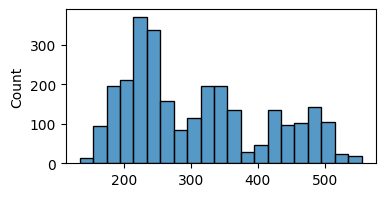

In [82]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [83]:
data

Dataset({
    features: ['prompt', 'answer', 'data_source', 'question', 'story'],
    num_rows: 2800
})

In [36]:
data.to_parquet('../data/train/ToM_train_HiEx.parquet')

Creating parquet from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 395.08ba/s]


6867600

**Verl**

In [ ]:
# add a row to each data item that represents a unique id
def make_map_fn(split):

    def process_fn(example, idx):
        question = example.pop('question')

        question = SYSTEM_PROMPT + " Question: " + question

        solution = example.pop('answer')
        data = {
            "data_source": 'MATH_Hard',
            "prompt": [{
                "role": "user",
                "content": question
            }],
            "ability": "math",
            "reward_model": {
                "style": "rule",
                "ground_truth": solution
            },
            "extra_info": {
                'split': split,
                'index': idx
            }
        }
        return data

    return process_fn

In [85]:
data

Dataset({
    features: ['prompt', 'answer', 'data_source', 'question', 'story'],
    num_rows: 2800
})

In [43]:
extra_info = []
for i, row in dft.iterrows():
    extra_info.append({'question_type':row['question_type'], 
                       'question_order':row['nth_order'],
                       'is_interesting':row['is_interesting'],
                       'story_type':row['story_type']
                       })
dft['extra_info'] = extra_info

In [41]:
dfh[:1000].head(2)

,deception,story_length,question_order,sample_id,story,question,choices,answer,question_old,answer_old,...,reward_model,extra_info,story_structure,infilled_story,question_type,params,nth_order,is_interesting,story_type,story_structure_wn
0,False,1.0,4.0,89.0,"Benjamin, Emily, Mason, Evelyn and Jackson ent...",Where does Jackson think Benjamin thinks Emily...,"A. green_treasure_chest, B. green_bottle, C. g...",green_suitcase,Where does Jackson think Benjamin thinks Emily...,green_suitcase,...,"{'ground_truth': 'green_suitcase', 'style': 'r...","{'deception': False, 'question_order': 4, 'sto...",None,None,None,None,NaN,None,None,None
1,True,3.0,4.0,46.0,"Mason, Noah, Hannah, Ethan and Alexander enter...",Where does Hannah think Noah thinks Mason thin...,"A. green_box, B. blue_container, C. blue_pantr...",red_drawer,Where does Hannah think Noah thinks Mason thin...,red_drawer,...,"{'ground_truth': 'red_drawer', 'style': 'rule'}","{'deception': True, 'question_order': 4, 'stor...",None,None,None,None,NaN,None,None,None


In [46]:
test_tomi = load_dataset('parquet', data_files='../data/test/test_tomi.parquet')['train']

Generating train split: 5994 examples [00:00, 952911.28 examples/s]


In [49]:
dftomi = pd.DataFrame(test_tomi)

In [50]:
dftomi.head(2)

,story,question,answer,question_type,question_type2,prompt
0,Jackson entered the hall. Chloe entered the ha...,Where was the boots at the beginning?,bathtub,true_belief,memory,[{'content': 'You are a helpful assistant. The...
1,Jackson entered the hall. Chloe entered the ha...,Where will Chloe look for the boots?,pantry,true_belief,first_order_1_no_tom,[{'content': 'You are a helpful assistant. The...


In [51]:
extra_info = []
for i, row in dftomi.iterrows():
    extra_info.append({'question_type':row['question_type'], 
                       'question_type2':row['question_type2']
                       })
dftomi['extra_info'] = extra_info

In [52]:
dftomi['data_source']='tomi'

In [53]:
col_test = ['prompt', 'answer', 'data_source', 'question', 'story', 'extra_info']

In [57]:
df_test = pd.concat([dft.loc[:, col_test], dfh.loc[:, col_test], dftomi.loc[:, col_test]], ignore_index=True)
df_test = df_test.sample(frac=1, replace=False, ignore_index=True)

In [58]:
len(df_test)

8660

In [59]:
df_test.groupby('data_source').story.count()

data_source
explore_tom    1066
hi_tom         1000
tomi           5994
Name: story, dtype: int64

In [ ]:
data = Dataset.from_pandas(df_test)
data.to_parquet('../data/test/ToM_test_HiExTi.parquet')

Creating parquet from Arrow format: 100%|██████████| 9/9 [00:00<00:00, 473.77ba/s]


13345802

In [61]:
data

Dataset({
    features: ['prompt', 'answer', 'data_source', 'question', 'story', 'extra_info'],
    num_rows: 8660
})